In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
import torch.utils.data as data
from torchvision import transforms
import torchvision
import torchvision.utils as utils


#カレントディレクトリがipynbの場所になってる
#
import sys,os
sys.path.append(os.pardir)

import py_func.Deep_learning_torch_func as DL
import py_func.models_func as my_model
import py_func.dat_rb_func as drb
import py_func.my_numpy_class as mnc
import py_func.my_torch_class as mtc
import py_func.models_func as my_model
import py_func.Deep_learning_torch_func as DL
import py_func.dat_rb_func as drb

from torchinfo import summary

from torch.optim import lr_scheduler

import numpy as np

In [2]:
import torchvision.datasets as dset
from torchvision.datasets import ImageFolder


In [3]:
import py_func.gan.gan_model as ganmd
import py_func.gan.gan_func as ganf

In [4]:
#Imagenet
imgnet_root = '../imagenet/dog'

# ImageFolderの前処理, ImageFolderのtransoformに設定
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1辺が224ピクセルの正方形に変換
    transforms.ToTensor(),   # Tensor行列に変換
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ImageFolderのインスタンス生成
imgnetset = ImageFolder(root=imgnet_root, # 画像が保存されているフォルダのパス
                       transform=valid_transform) # Tensorへの変換



In [5]:
chlist = [6000, 2048, 1024, 512, 256, 128, 64, 32, 3]
klist = [3, 3, 3, 3, 3, 3, 2, 2]
strdlist = [1, 1, 2, 2, 2, 2, 2, 2]
padlist = [0, 0, 1, 1, 2, 2, 2, 2]
opadlist = [0, 0, 0, 0, 0, 0, 0, 0]

gene = ganmd.Generator(chlist, klist, strdlist, padlist, opadlist)
summary(model = gene, input_size = (1, 6000, 1, 1), depth = 4)

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     --                        --
├─Sequential: 1-1                             [1, 3, 224, 224]          --
│    └─Convtp_Bn_ReLu: 2-1                    [1, 2048, 3, 3]           --
│    │    └─Sequential: 3-1                   [1, 2048, 3, 3]           --
│    │    │    └─ConvTranspose2d: 4-1         [1, 2048, 3, 3]           110,594,048
│    │    │    └─BatchNorm2d: 4-2             [1, 2048, 3, 3]           4,096
│    │    │    └─ReLU: 4-3                    [1, 2048, 3, 3]           --
│    └─Convtp_Bn_ReLu: 2-2                    [1, 1024, 5, 5]           --
│    │    └─Sequential: 3-2                   [1, 1024, 5, 5]           --
│    │    │    └─ConvTranspose2d: 4-4         [1, 1024, 5, 5]           18,875,392
│    │    │    └─BatchNorm2d: 4-5             [1, 1024, 5, 5]           2,048
│    │    │    └─ReLU: 4-6                    [1, 1024, 5, 5]           

In [6]:
chlist = [3, 32, 64, 128, 256, 512, 1]
klist = [4, 4, 4, 4, 4, 4]
strdlist = [2, 2, 2, 2, 2, 2]
padlist = [1, 1, 0, 0, 0, 0]
ngsllist = [0.2, 0.2, 0.2, 0.2, 0.2, 0]

disc = ganmd.Discriminator(chlist, klist, strdlist, padlist, ngsllist)
summary(model = disc, input_size = (1, 3, 224, 224), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv_LeakyReLU: 2-1               [1, 32, 112, 112]         --
│    │    └─Sequential: 3-1              [1, 32, 112, 112]         --
│    │    │    └─Conv2d: 4-1             [1, 32, 112, 112]         1,568
│    │    │    └─LeakyReLU: 4-2          [1, 32, 112, 112]         --
│    └─Conv_Bn_LeakyReLU: 2-2            [1, 64, 56, 56]           --
│    │    └─Sequential: 3-2              [1, 64, 56, 56]           --
│    │    │    └─Conv2d: 4-3             [1, 64, 56, 56]           32,832
│    │    │    └─BatchNorm2d: 4-4        [1, 64, 56, 56]           128
│    │    │    └─LeakyReLU: 4-5          [1, 64, 56, 56]           --
│    └─Conv_Bn_LeakyReLU: 2-3            [1, 128, 27, 27]          --
│    │    └─Sequential: 3-3              [1, 128, 27, 27]          --
│    │ 

In [7]:
batch_size = 16
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(imgnetset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 6000
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)


# オプティマイザ−のセットアップ
lrd = 0.00025
lrg = 0.002
beta1 = 0.5
optimizerD = optim.Adam(disc.parameters(), lr=lrd, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(gene.parameters(), lr=lrg, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [8]:
epochs = 100
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN/DCGAN/imagenet_dog'
dispinterval = 30
testgen_interval = 1


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_gan(epochs, dl, device, nz, disc, gene, 
                                                                     criterion, optimizerG, optimizerD, 
                                                                     dispinterval, 
                                                                     testgen_interval, fixed_noise, outf)

[1/100][1/188] Loss_D: 1.478 Loss_G: 5.657 D(x): 0.434 D(G(z)): 0.456/0.004
[1/100][31/188] Loss_D: 0.938 Loss_G: 2.901 D(x): 0.823 D(G(z)): 0.510/0.056
[1/100][61/188] Loss_D: 1.757 Loss_G: 4.132 D(x): 0.940 D(G(z)): 0.815/0.017
[1/100][91/188] Loss_D: 0.691 Loss_G: 2.044 D(x): 0.968 D(G(z)): 0.480/0.130
[1/100][121/188] Loss_D: 0.355 Loss_G: 2.786 D(x): 0.959 D(G(z)): 0.267/0.062
[1/100][151/188] Loss_D: 0.203 Loss_G: 2.108 D(x): 0.988 D(G(z)): 0.173/0.127
[1/100][181/188] Loss_D: 0.158 Loss_G: 3.227 D(x): 0.978 D(G(z)): 0.126/0.040
-----------エポック1--------------
epochtime:0.4393分
[2/100][1/188] Loss_D: 0.235 Loss_G: 2.649 D(x): 0.985 D(G(z)): 0.194/0.094
[2/100][31/188] Loss_D: 0.627 Loss_G: 7.124 D(x): 0.979 D(G(z)): 0.438/0.001
[2/100][61/188] Loss_D: 0.044 Loss_G: 3.912 D(x): 0.991 D(G(z)): 0.035/0.024
[2/100][91/188] Loss_D: 0.031 Loss_G: 5.191 D(x): 0.988 D(G(z)): 0.019/0.011
[2/100][121/188] Loss_D: 0.023 Loss_G: 5.098 D(x): 0.993 D(G(z)): 0.017/0.006
[2/100][151/188] Loss_D: 

-----------エポック14--------------
epochtime:0.4320分
[15/100][1/188] Loss_D: 1.405 Loss_G: 1.748 D(x): 0.550 D(G(z)): 0.497/0.208
[15/100][31/188] Loss_D: 2.291 Loss_G: 1.295 D(x): 0.613 D(G(z)): 0.783/0.300
[15/100][61/188] Loss_D: 1.350 Loss_G: 1.567 D(x): 0.520 D(G(z)): 0.447/0.225
[15/100][91/188] Loss_D: 1.489 Loss_G: 1.175 D(x): 0.504 D(G(z)): 0.456/0.347
[15/100][121/188] Loss_D: 1.290 Loss_G: 1.722 D(x): 0.687 D(G(z)): 0.552/0.214
[15/100][151/188] Loss_D: 1.247 Loss_G: 1.611 D(x): 0.631 D(G(z)): 0.477/0.230
[15/100][181/188] Loss_D: 1.355 Loss_G: 1.294 D(x): 0.527 D(G(z)): 0.441/0.309
-----------エポック15--------------
epochtime:0.4329分
[16/100][1/188] Loss_D: 1.409 Loss_G: 1.254 D(x): 0.491 D(G(z)): 0.472/0.307
[16/100][31/188] Loss_D: 1.381 Loss_G: 1.300 D(x): 0.400 D(G(z)): 0.282/0.287
[16/100][61/188] Loss_D: 1.231 Loss_G: 1.863 D(x): 0.729 D(G(z)): 0.538/0.205
[16/100][91/188] Loss_D: 1.145 Loss_G: 1.976 D(x): 0.615 D(G(z)): 0.437/0.159
[16/100][121/188] Loss_D: 1.311 Loss_G: 1

[28/100][151/188] Loss_D: 1.376 Loss_G: 1.749 D(x): 0.624 D(G(z)): 0.551/0.195
[28/100][181/188] Loss_D: 1.466 Loss_G: 1.267 D(x): 0.634 D(G(z)): 0.607/0.295
-----------エポック28--------------
epochtime:0.4316分
[29/100][1/188] Loss_D: 1.406 Loss_G: 1.226 D(x): 0.466 D(G(z)): 0.416/0.314
[29/100][31/188] Loss_D: 1.093 Loss_G: 1.338 D(x): 0.540 D(G(z)): 0.353/0.276
[29/100][61/188] Loss_D: 1.180 Loss_G: 2.179 D(x): 0.663 D(G(z)): 0.516/0.129
[29/100][91/188] Loss_D: 1.119 Loss_G: 1.813 D(x): 0.557 D(G(z)): 0.359/0.180
[29/100][121/188] Loss_D: 1.310 Loss_G: 1.342 D(x): 0.629 D(G(z)): 0.553/0.269
[29/100][151/188] Loss_D: 1.378 Loss_G: 1.453 D(x): 0.491 D(G(z)): 0.439/0.256
[29/100][181/188] Loss_D: 1.714 Loss_G: 1.466 D(x): 0.337 D(G(z)): 0.421/0.256
-----------エポック29--------------
epochtime:0.4308分
[30/100][1/188] Loss_D: 1.437 Loss_G: 1.153 D(x): 0.422 D(G(z)): 0.406/0.325
[30/100][31/188] Loss_D: 1.365 Loss_G: 1.322 D(x): 0.421 D(G(z)): 0.349/0.294
[30/100][61/188] Loss_D: 1.557 Loss_G: 

[42/100][91/188] Loss_D: 1.487 Loss_G: 1.348 D(x): 0.412 D(G(z)): 0.404/0.276
[42/100][121/188] Loss_D: 0.997 Loss_G: 1.741 D(x): 0.662 D(G(z)): 0.416/0.193
[42/100][151/188] Loss_D: 1.385 Loss_G: 1.403 D(x): 0.531 D(G(z)): 0.489/0.263
[42/100][181/188] Loss_D: 1.216 Loss_G: 1.414 D(x): 0.547 D(G(z)): 0.419/0.258
-----------エポック42--------------
epochtime:0.4308分
[43/100][1/188] Loss_D: 1.418 Loss_G: 1.586 D(x): 0.570 D(G(z)): 0.552/0.219
[43/100][31/188] Loss_D: 1.482 Loss_G: 1.506 D(x): 0.560 D(G(z)): 0.569/0.241
[43/100][61/188] Loss_D: 1.149 Loss_G: 1.239 D(x): 0.548 D(G(z)): 0.390/0.298
[43/100][91/188] Loss_D: 1.366 Loss_G: 1.273 D(x): 0.516 D(G(z)): 0.473/0.288
[43/100][121/188] Loss_D: 1.526 Loss_G: 1.279 D(x): 0.571 D(G(z)): 0.586/0.296
[43/100][151/188] Loss_D: 0.923 Loss_G: 1.892 D(x): 0.610 D(G(z)): 0.321/0.161
[43/100][181/188] Loss_D: 1.159 Loss_G: 1.716 D(x): 0.609 D(G(z)): 0.468/0.191
-----------エポック43--------------
epochtime:0.4312分
[44/100][1/188] Loss_D: 1.341 Loss_G:

[56/100][31/188] Loss_D: 1.075 Loss_G: 1.708 D(x): 0.612 D(G(z)): 0.420/0.196
[56/100][61/188] Loss_D: 1.211 Loss_G: 1.907 D(x): 0.542 D(G(z)): 0.408/0.156
[56/100][91/188] Loss_D: 1.242 Loss_G: 1.911 D(x): 0.535 D(G(z)): 0.426/0.159
[56/100][121/188] Loss_D: 1.490 Loss_G: 2.864 D(x): 0.713 D(G(z)): 0.662/0.063
[56/100][151/188] Loss_D: 1.565 Loss_G: 2.636 D(x): 0.508 D(G(z)): 0.536/0.084
[56/100][181/188] Loss_D: 1.071 Loss_G: 2.058 D(x): 0.645 D(G(z)): 0.440/0.139
-----------エポック56--------------
epochtime:0.4325分
[57/100][1/188] Loss_D: 1.369 Loss_G: 1.744 D(x): 0.526 D(G(z)): 0.479/0.184
[57/100][31/188] Loss_D: 1.583 Loss_G: 2.286 D(x): 0.329 D(G(z)): 0.273/0.123
[57/100][61/188] Loss_D: 1.420 Loss_G: 2.070 D(x): 0.564 D(G(z)): 0.534/0.136
[57/100][91/188] Loss_D: 1.181 Loss_G: 1.947 D(x): 0.651 D(G(z)): 0.450/0.189
[57/100][121/188] Loss_D: 1.127 Loss_G: 2.565 D(x): 0.694 D(G(z)): 0.507/0.091
[57/100][151/188] Loss_D: 1.154 Loss_G: 1.359 D(x): 0.543 D(G(z)): 0.377/0.270
[57/100][1

-----------エポック69--------------
epochtime:0.4376分
[70/100][1/188] Loss_D: 0.960 Loss_G: 2.203 D(x): 0.672 D(G(z)): 0.401/0.125
[70/100][31/188] Loss_D: 0.897 Loss_G: 2.483 D(x): 0.768 D(G(z)): 0.450/0.090
[70/100][61/188] Loss_D: 1.062 Loss_G: 2.550 D(x): 0.646 D(G(z)): 0.445/0.086
[70/100][91/188] Loss_D: 1.261 Loss_G: 2.654 D(x): 0.575 D(G(z)): 0.474/0.082
[70/100][121/188] Loss_D: 1.466 Loss_G: 2.348 D(x): 0.606 D(G(z)): 0.574/0.110
[70/100][151/188] Loss_D: 1.071 Loss_G: 1.920 D(x): 0.599 D(G(z)): 0.352/0.151
[70/100][181/188] Loss_D: 0.916 Loss_G: 2.691 D(x): 0.750 D(G(z)): 0.436/0.085
-----------エポック70--------------
epochtime:0.4409分
[71/100][1/188] Loss_D: 1.864 Loss_G: 3.335 D(x): 0.806 D(G(z)): 0.793/0.040
[71/100][31/188] Loss_D: 1.141 Loss_G: 2.117 D(x): 0.545 D(G(z)): 0.378/0.132
[71/100][61/188] Loss_D: 1.029 Loss_G: 1.910 D(x): 0.575 D(G(z)): 0.322/0.168
[71/100][91/188] Loss_D: 0.879 Loss_G: 2.410 D(x): 0.740 D(G(z)): 0.421/0.102
[71/100][121/188] Loss_D: 0.976 Loss_G: 2

[83/100][151/188] Loss_D: 1.117 Loss_G: 1.602 D(x): 0.589 D(G(z)): 0.419/0.217
[83/100][181/188] Loss_D: 1.247 Loss_G: 1.609 D(x): 0.614 D(G(z)): 0.500/0.211
-----------エポック83--------------
epochtime:0.4437分
[84/100][1/188] Loss_D: 1.306 Loss_G: 1.473 D(x): 0.466 D(G(z)): 0.395/0.234
[84/100][31/188] Loss_D: 1.219 Loss_G: 1.579 D(x): 0.652 D(G(z)): 0.514/0.213
[84/100][61/188] Loss_D: 1.706 Loss_G: 1.926 D(x): 0.533 D(G(z)): 0.635/0.159
[84/100][91/188] Loss_D: 1.253 Loss_G: 1.555 D(x): 0.555 D(G(z)): 0.464/0.220
[84/100][121/188] Loss_D: 1.640 Loss_G: 1.334 D(x): 0.399 D(G(z)): 0.487/0.268
[84/100][151/188] Loss_D: 0.879 Loss_G: 2.680 D(x): 0.763 D(G(z)): 0.445/0.074
[84/100][181/188] Loss_D: 1.397 Loss_G: 1.399 D(x): 0.435 D(G(z)): 0.393/0.270
-----------エポック84--------------
epochtime:0.4406分
[85/100][1/188] Loss_D: 1.233 Loss_G: 1.808 D(x): 0.653 D(G(z)): 0.530/0.190
[85/100][31/188] Loss_D: 1.298 Loss_G: 1.603 D(x): 0.532 D(G(z)): 0.442/0.209
[85/100][61/188] Loss_D: 1.316 Loss_G: 

[97/100][91/188] Loss_D: 0.037 Loss_G: 4.487 D(x): 0.994 D(G(z)): 0.030/0.013
[97/100][121/188] Loss_D: 0.038 Loss_G: 6.033 D(x): 0.966 D(G(z)): 0.003/0.004
[97/100][151/188] Loss_D: 0.111 Loss_G: 3.157 D(x): 0.991 D(G(z)): 0.097/0.045
[97/100][181/188] Loss_D: 0.081 Loss_G: 5.396 D(x): 0.981 D(G(z)): 0.059/0.005
-----------エポック97--------------
epochtime:0.4327分
[98/100][1/188] Loss_D: 0.007 Loss_G: 8.392 D(x): 0.993 D(G(z)): 0.000/0.000
[98/100][31/188] Loss_D: 0.714 Loss_G: 5.854 D(x): 0.524 D(G(z)): 0.001/0.004
[98/100][61/188] Loss_D: 0.108 Loss_G: 3.227 D(x): 0.986 D(G(z)): 0.089/0.041
[98/100][91/188] Loss_D: 1.165 Loss_G: 7.653 D(x): 0.983 D(G(z)): 0.673/0.001
[98/100][121/188] Loss_D: 0.334 Loss_G: 4.519 D(x): 0.964 D(G(z)): 0.255/0.011
[98/100][151/188] Loss_D: 0.436 Loss_G: 3.925 D(x): 0.957 D(G(z)): 0.308/0.024
[98/100][181/188] Loss_D: 0.064 Loss_G: 4.028 D(x): 0.978 D(G(z)): 0.041/0.019
-----------エポック98--------------
epochtime:0.4321分
[99/100][1/188] Loss_D: 0.499 Loss_G:

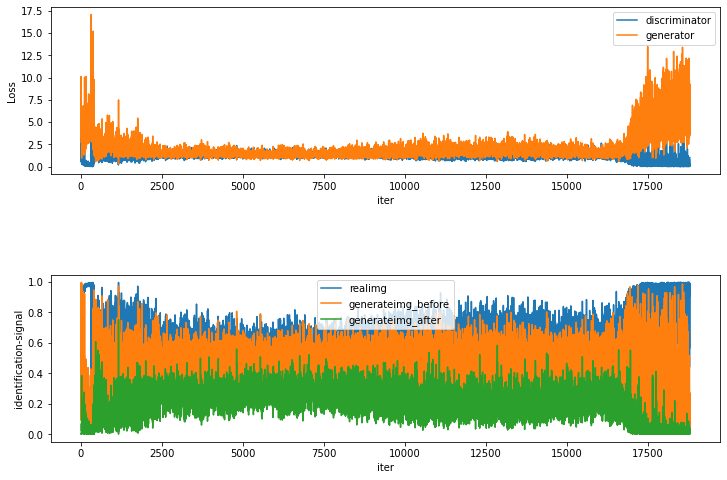

In [9]:
ganf.display_GAN_curv(12, 8, 10, 10, D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out)

In [4]:
#Imagenet
imgnet_root = '../imagenet/ILSVRC2012_img_val_for_ImageFolder'

# ImageFolderの前処理, ImageFolderのtransoformに設定
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1辺が224ピクセルの正方形に変換
    transforms.ToTensor(),   # Tensor行列に変換
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ImageFolderのインスタンス生成
imgnetset = ImageFolder(root=imgnet_root, # 画像が保存されているフォルダのパス
                       transform=valid_transform) # Tensorへの変換



In [5]:
len(imgnetset), imgnetset[0][0].shape

(50000, torch.Size([3, 224, 224]))

In [6]:
imgnetset[0][0]

tensor([[[-0.0353,  0.0745,  0.2941,  ...,  0.4275,  0.5608,  0.4902],
         [-0.2000,  0.4039,  0.5059,  ...,  0.3725,  0.5373,  0.5059],
         [ 0.4353,  0.0667,  0.3176,  ...,  0.2471,  0.2863,  0.2157],
         ...,
         [ 0.0510, -0.0588, -0.0510,  ...,  0.2706,  0.0902, -0.1216],
         [-0.1529, -0.1608, -0.0980,  ...,  0.1922, -0.0824, -0.1843],
         [-0.2627, -0.2627, -0.1373,  ..., -0.0353, -0.1843, -0.2314]],

        [[ 0.0431,  0.0510,  0.3098,  ...,  0.4745,  0.6314,  0.5765],
         [-0.1765,  0.4353,  0.6235,  ...,  0.4196,  0.6078,  0.5922],
         [ 0.4745,  0.2078,  0.5765,  ...,  0.3176,  0.3882,  0.3255],
         ...,
         [ 0.3961,  0.3020,  0.1922,  ...,  0.5137,  0.1686, -0.1137],
         [ 0.2235,  0.1451,  0.0902,  ...,  0.2863, -0.0588, -0.1529],
         [ 0.0353,  0.0353,  0.1686,  ..., -0.0039, -0.1529, -0.1843]],

        [[-0.4118, -0.3020,  0.2627,  ...,  0.4353,  0.5765,  0.4980],
         [-0.3412,  0.0353,  0.5451,  ...,  0

In [7]:
imgnetset[0][1]

0

In [8]:
##########----------------------------DCGAN------------------------------###############

In [9]:
#IMAGENET

In [10]:
chlist = [6000, 2048, 1024, 512, 256, 128, 64, 3]
klist = [3, 3, 4, 4, 4, 4, 4]
strdlist = [1, 2, 2, 2, 2, 2, 2]
padlist = [0, 0, 1, 1, 1, 1, 1]
opadlist = [0, 0, 0, 0, 0, 0, 0]

gene = ganmd.Generator(chlist, klist, strdlist, padlist, opadlist)
summary(model = gene, input_size = (1, 6000, 1, 1), depth = 4)

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     --                        --
├─Sequential: 1-1                             [1, 3, 224, 224]          --
│    └─Convtp_Bn_ReLu: 2-1                    [1, 2048, 3, 3]           --
│    │    └─Sequential: 3-1                   [1, 2048, 3, 3]           --
│    │    │    └─ConvTranspose2d: 4-1         [1, 2048, 3, 3]           110,594,048
│    │    │    └─BatchNorm2d: 4-2             [1, 2048, 3, 3]           4,096
│    │    │    └─ReLU: 4-3                    [1, 2048, 3, 3]           --
│    └─Convtp_Bn_ReLu: 2-2                    [1, 1024, 7, 7]           --
│    │    └─Sequential: 3-2                   [1, 1024, 7, 7]           --
│    │    │    └─ConvTranspose2d: 4-4         [1, 1024, 7, 7]           18,875,392
│    │    │    └─BatchNorm2d: 4-5             [1, 1024, 7, 7]           2,048
│    │    │    └─ReLU: 4-6                    [1, 1024, 7, 7]           

In [11]:
chlist = [3, 16, 32, 64, 128, 256, 1]
klist = [4, 4, 4, 4, 4, 4]
strdlist = [2, 2, 2, 2, 2, 2]
padlist = [1, 1, 0, 0, 0, 0]
ngsllist = [0.2, 0.2, 0.2, 0.2, 0.2, 0]

disc = ganmd.Discriminator(chlist, klist, strdlist, padlist, ngsllist)
summary(model = disc, input_size = (1, 3, 224, 224), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv_LeakyReLU: 2-1               [1, 16, 112, 112]         --
│    │    └─Sequential: 3-1              [1, 16, 112, 112]         --
│    │    │    └─Conv2d: 4-1             [1, 16, 112, 112]         784
│    │    │    └─LeakyReLU: 4-2          [1, 16, 112, 112]         --
│    └─Conv_Bn_LeakyReLU: 2-2            [1, 32, 56, 56]           --
│    │    └─Sequential: 3-2              [1, 32, 56, 56]           --
│    │    │    └─Conv2d: 4-3             [1, 32, 56, 56]           8,224
│    │    │    └─BatchNorm2d: 4-4        [1, 32, 56, 56]           64
│    │    │    └─LeakyReLU: 4-5          [1, 32, 56, 56]           --
│    └─Conv_Bn_LeakyReLU: 2-3            [1, 64, 27, 27]           --
│    │    └─Sequential: 3-3              [1, 64, 27, 27]           --
│    │    │

In [12]:
batch_size = 64
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(imgnetset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 6000
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)


# オプティマイザ−のセットアップ
lrd = 0.0001
lrg = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(disc.parameters(), lr=lrd, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(gene.parameters(), lr=lrg, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [13]:
epochs = 5
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN/DCGAN/imagenet'
dispinterval = 128
testgen_interval = 1


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_gan(epochs, dl, device, nz, disc, gene, 
                                                                     criterion, optimizerG, optimizerD, 
                                                                     dispinterval, 
                                                                     testgen_interval, fixed_noise, outf)

[1/5][1/782] Loss_D: 1.403 Loss_G: 1.137 D(x): 0.490 D(G(z)): 0.484/0.329
[1/5][129/782] Loss_D: 4.287 Loss_G: 0.245 D(x): 0.258 D(G(z)): 0.945/0.782
[1/5][257/782] Loss_D: 2.880 Loss_G: 0.406 D(x): 0.291 D(G(z)): 0.803/0.666
[1/5][385/782] Loss_D: 2.092 Loss_G: 0.512 D(x): 0.375 D(G(z)): 0.663/0.600
[1/5][513/782] Loss_D: 1.543 Loss_G: 0.674 D(x): 0.466 D(G(z)): 0.541/0.510
[1/5][641/782] Loss_D: 1.507 Loss_G: 0.704 D(x): 0.474 D(G(z)): 0.532/0.495
[1/5][769/782] Loss_D: 1.462 Loss_G: 0.710 D(x): 0.489 D(G(z)): 0.526/0.492
[2/5][1/782] Loss_D: 1.456 Loss_G: 0.720 D(x): 0.490 D(G(z)): 0.524/0.487
[2/5][129/782] Loss_D: 1.457 Loss_G: 0.715 D(x): 0.496 D(G(z)): 0.530/0.489
[2/5][257/782] Loss_D: 1.361 Loss_G: 0.775 D(x): 0.535 D(G(z)): 0.520/0.461
[2/5][385/782] Loss_D: 1.268 Loss_G: 0.824 D(x): 0.567 D(G(z)): 0.503/0.439
[2/5][513/782] Loss_D: 0.847 Loss_G: 1.131 D(x): 0.770 D(G(z)): 0.443/0.323
[2/5][641/782] Loss_D: 1.463 Loss_G: 0.775 D(x): 0.473 D(G(z)): 0.506/0.462
[2/5][769/782] L

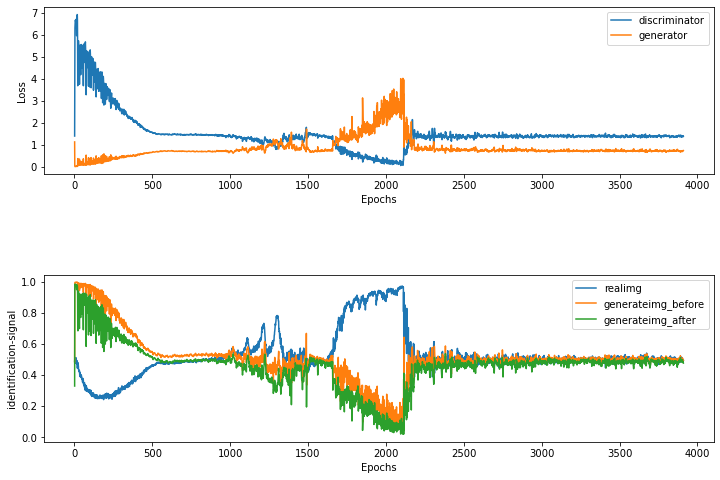

In [14]:
ganf.display_GAN_curv(12, 8, 10, 10, D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out)

In [46]:
chlist = [100, 512, 256, 128, 1]
klist = [3, 3, 4, 4]
strdlist = [1, 2, 2, 2]
padlist = [0, 0, 1, 1]
opadlist = [0, 0, 0, 0]

gene = ganmd.Generator(chlist, klist, strdlist, padlist, opadlist)

In [47]:
gene

Generator(
  (Deconvs): Sequential(
    (0): Convtp_Bn_ReLu(
      (Deconv): Sequential(
        (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): Convtp_Bn_ReLu(
      (Deconv): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): Convtp_Bn_ReLu(
      (Deconv): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (3): Convtp_Tanh(
      (Deconv): Sequential(
        (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): Tanh()
      )
    )
  )
)

In [48]:
summary(model = gene, input_size = (1, 100, 1, 1), depth = 4)

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     --                        --
├─Sequential: 1-1                             [1, 1, 28, 28]            --
│    └─Convtp_Bn_ReLu: 2-1                    [1, 512, 3, 3]            --
│    │    └─Sequential: 3-1                   [1, 512, 3, 3]            --
│    │    │    └─ConvTranspose2d: 4-1         [1, 512, 3, 3]            461,312
│    │    │    └─BatchNorm2d: 4-2             [1, 512, 3, 3]            1,024
│    │    │    └─ReLU: 4-3                    [1, 512, 3, 3]            --
│    └─Convtp_Bn_ReLu: 2-2                    [1, 256, 7, 7]            --
│    │    └─Sequential: 3-2                   [1, 256, 7, 7]            --
│    │    │    └─ConvTranspose2d: 4-4         [1, 256, 7, 7]            1,179,904
│    │    │    └─BatchNorm2d: 4-5             [1, 256, 7, 7]            512
│    │    │    └─ReLU: 4-6                    [1, 256, 7, 7]            --
│   

In [49]:
chlist = [1, 128, 256, 512, 1]
klist = [4, 4, 3, 3]
strdlist = [2, 2, 2, 1]
padlist = [1, 1, 0, 0]
ngsllist = [0.2, 0.2, 0.2, 0]

disc = ganmd.Discriminator(chlist, klist, strdlist, padlist, ngsllist)

In [50]:
disc

Discriminator(
  (Convs): Sequential(
    (0): Conv_LeakyReLU(
      (CNN): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): Conv_Bn_LeakyReLU(
      (CNN): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): Conv_Bn_LeakyReLU(
      (CNN): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): Conv_Sigmoid(
      (CNN): Sequential(
        (0): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
        (1): Sigmoid()
      )
    )
  )
)

In [51]:
summary(model = disc, input_size = (1, 1, 28, 28), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv_LeakyReLU: 2-1               [1, 128, 14, 14]          --
│    │    └─Sequential: 3-1              [1, 128, 14, 14]          --
│    │    │    └─Conv2d: 4-1             [1, 128, 14, 14]          2,176
│    │    │    └─LeakyReLU: 4-2          [1, 128, 14, 14]          --
│    └─Conv_Bn_LeakyReLU: 2-2            [1, 256, 7, 7]            --
│    │    └─Sequential: 3-2              [1, 256, 7, 7]            --
│    │    │    └─Conv2d: 4-3             [1, 256, 7, 7]            524,544
│    │    │    └─BatchNorm2d: 4-4        [1, 256, 7, 7]            512
│    │    │    └─LeakyReLU: 4-5          [1, 256, 7, 7]            --
│    └─Conv_Bn_LeakyReLU: 2-3            [1, 512, 3, 3]            --
│    │    └─Sequential: 3-3              [1, 512, 3, 3]            --
│    │

In [4]:
dataset = dset.MNIST(root='../torch_dataset/mnist_root', download=True, train=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,)) ])) 

In [11]:
batch_size = 256
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(dataset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)


# オプティマイザ−のセットアップ
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(gene.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [17]:
gene.children()

<generator object Module.children at 0x000002088B5BBF20>

In [18]:
children = gene.children()

In [20]:
print(children)

<generator object Module.children at 0x00000208934DD120>


In [23]:
gene.Deconvs[0].Deconv[0]

ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1))

In [15]:
epochs = 30
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN'
dispinterval = 64
testgen_interval = 5


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_gan(epochs, dl, device, nz, disc, gene, criterion, \
                                                     optimizerG, optimizerD, 
                                                     dispinterval,
                                                     testgen_interval, fixed_noise, outf)

[1/30][1/235] Loss_D: 1.355 Loss_G: 1.388 D(x): 0.532 D(G(z)): 0.500/0.260
[1/30][65/235] Loss_D: 0.004 Loss_G: 6.837 D(x): 0.998 D(G(z)): 0.002/0.001
[1/30][129/235] Loss_D: 0.003 Loss_G: 7.296 D(x): 0.999 D(G(z)): 0.002/0.001
[1/30][193/235] Loss_D: 0.763 Loss_G: 3.102 D(x): 0.534 D(G(z)): 0.044/0.052
[2/30][1/235] Loss_D: 0.490 Loss_G: 3.035 D(x): 0.751 D(G(z)): 0.129/0.071
[2/30][65/235] Loss_D: 0.733 Loss_G: 2.387 D(x): 0.573 D(G(z)): 0.078/0.118
[2/30][129/235] Loss_D: 1.642 Loss_G: 0.536 D(x): 0.252 D(G(z)): 0.042/0.615
[2/30][193/235] Loss_D: 0.846 Loss_G: 1.422 D(x): 0.685 D(G(z)): 0.345/0.264
[3/30][1/235] Loss_D: 0.820 Loss_G: 1.317 D(x): 0.654 D(G(z)): 0.296/0.296
[3/30][65/235] Loss_D: 0.837 Loss_G: 1.205 D(x): 0.595 D(G(z)): 0.241/0.325
[3/30][129/235] Loss_D: 1.263 Loss_G: 0.610 D(x): 0.354 D(G(z)): 0.127/0.565
[3/30][193/235] Loss_D: 0.776 Loss_G: 0.697 D(x): 0.579 D(G(z)): 0.166/0.519
[4/30][1/235] Loss_D: 0.983 Loss_G: 1.930 D(x): 0.834 D(G(z)): 0.523/0.164
[4/30][65/

[27/30][193/235] Loss_D: 0.504 Loss_G: 2.247 D(x): 0.772 D(G(z)): 0.176/0.145
[28/30][1/235] Loss_D: 0.448 Loss_G: 3.165 D(x): 0.859 D(G(z)): 0.222/0.064
[28/30][65/235] Loss_D: 0.706 Loss_G: 0.817 D(x): 0.571 D(G(z)): 0.062/0.503
[28/30][129/235] Loss_D: 1.099 Loss_G: 3.560 D(x): 0.898 D(G(z)): 0.551/0.047
[28/30][193/235] Loss_D: 0.517 Loss_G: 1.688 D(x): 0.749 D(G(z)): 0.159/0.263
[29/30][1/235] Loss_D: 0.494 Loss_G: 1.820 D(x): 0.720 D(G(z)): 0.106/0.217
[29/30][65/235] Loss_D: 0.876 Loss_G: 3.975 D(x): 0.967 D(G(z)): 0.504/0.037
[29/30][129/235] Loss_D: 0.475 Loss_G: 1.403 D(x): 0.719 D(G(z)): 0.095/0.307
[29/30][193/235] Loss_D: 0.780 Loss_G: 2.536 D(x): 0.779 D(G(z)): 0.352/0.117
[30/30][1/235] Loss_D: 0.402 Loss_G: 2.265 D(x): 0.816 D(G(z)): 0.144/0.147
[30/30][65/235] Loss_D: 0.533 Loss_G: 2.476 D(x): 0.904 D(G(z)): 0.308/0.124
[30/30][129/235] Loss_D: 0.607 Loss_G: 1.980 D(x): 0.677 D(G(z)): 0.140/0.197
[30/30][193/235] Loss_D: 0.625 Loss_G: 1.474 D(x): 0.604 D(G(z)): 0.051/0

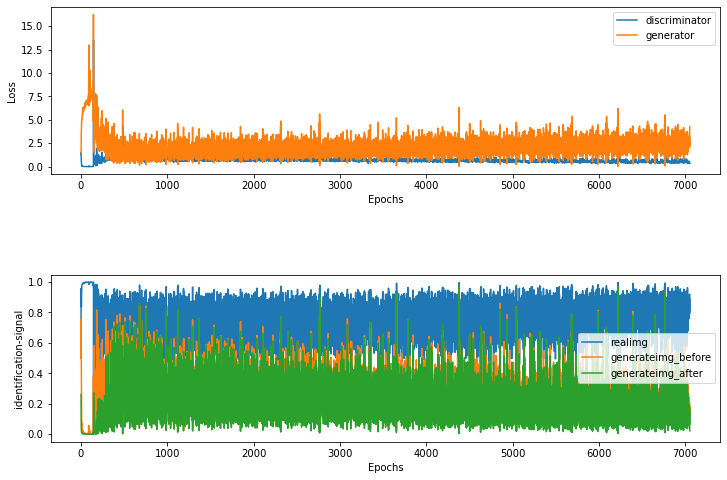

In [16]:
ganf.display_GAN_curv(12, 8, 10, 10, D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out)

In [14]:
fmset = dset.FashionMNIST(root='../torch_dataset/fashionmnist_root', download=True, train=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,)) ])) 

In [52]:
batch_size = 256
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(fmset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)


# オプティマイザ−のセットアップ
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(gene.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [53]:
epochs = 30
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN/DCGAN/fashion'
dispinterval = 64
testgen_interval = 5


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_gan(epochs, dl, device, nz, disc, gene, criterion, \
                                                     optimizerG, optimizerD, 
                                                     dispinterval,
                                                     testgen_interval, fixed_noise, outf)

[1/30][1/235] Loss_D: 1.441 Loss_G: 1.756 D(x): 0.489 D(G(z)): 0.494/0.181
[1/30][65/235] Loss_D: 0.038 Loss_G: 5.983 D(x): 0.970 D(G(z)): 0.003/0.003
[1/30][129/235] Loss_D: 0.351 Loss_G: 2.773 D(x): 0.894 D(G(z)): 0.199/0.067
[1/30][193/235] Loss_D: 0.972 Loss_G: 1.741 D(x): 0.565 D(G(z)): 0.256/0.211
[2/30][1/235] Loss_D: 0.663 Loss_G: 2.026 D(x): 0.682 D(G(z)): 0.197/0.151
[2/30][65/235] Loss_D: 0.790 Loss_G: 3.093 D(x): 0.800 D(G(z)): 0.395/0.059
[2/30][129/235] Loss_D: 0.783 Loss_G: 1.124 D(x): 0.598 D(G(z)): 0.132/0.367
[2/30][193/235] Loss_D: 0.619 Loss_G: 1.776 D(x): 0.683 D(G(z)): 0.173/0.197
[3/30][1/235] Loss_D: 0.748 Loss_G: 2.581 D(x): 0.752 D(G(z)): 0.329/0.094
[3/30][65/235] Loss_D: 0.802 Loss_G: 1.821 D(x): 0.690 D(G(z)): 0.304/0.194
[3/30][129/235] Loss_D: 0.817 Loss_G: 1.496 D(x): 0.594 D(G(z)): 0.199/0.261
[3/30][193/235] Loss_D: 0.815 Loss_G: 2.318 D(x): 0.749 D(G(z)): 0.368/0.119
[4/30][1/235] Loss_D: 0.791 Loss_G: 1.536 D(x): 0.637 D(G(z)): 0.246/0.245
[4/30][65/

[27/30][193/235] Loss_D: 0.624 Loss_G: 1.779 D(x): 0.730 D(G(z)): 0.222/0.219
[28/30][1/235] Loss_D: 0.548 Loss_G: 2.837 D(x): 0.803 D(G(z)): 0.235/0.106
[28/30][65/235] Loss_D: 0.706 Loss_G: 2.433 D(x): 0.817 D(G(z)): 0.341/0.118
[28/30][129/235] Loss_D: 0.652 Loss_G: 2.633 D(x): 0.864 D(G(z)): 0.349/0.099
[28/30][193/235] Loss_D: 1.500 Loss_G: 1.154 D(x): 0.305 D(G(z)): 0.030/0.460
[29/30][1/235] Loss_D: 0.733 Loss_G: 2.082 D(x): 0.755 D(G(z)): 0.278/0.185
[29/30][65/235] Loss_D: 0.639 Loss_G: 2.760 D(x): 0.832 D(G(z)): 0.322/0.085
[29/30][129/235] Loss_D: 0.499 Loss_G: 1.910 D(x): 0.771 D(G(z)): 0.181/0.205
[29/30][193/235] Loss_D: 0.680 Loss_G: 1.658 D(x): 0.716 D(G(z)): 0.231/0.237
[30/30][1/235] Loss_D: 0.757 Loss_G: 1.828 D(x): 0.657 D(G(z)): 0.193/0.245
[30/30][65/235] Loss_D: 0.915 Loss_G: 1.292 D(x): 0.509 D(G(z)): 0.086/0.366
[30/30][129/235] Loss_D: 0.754 Loss_G: 2.675 D(x): 0.828 D(G(z)): 0.378/0.095
[30/30][193/235] Loss_D: 0.559 Loss_G: 2.524 D(x): 0.786 D(G(z)): 0.236/0

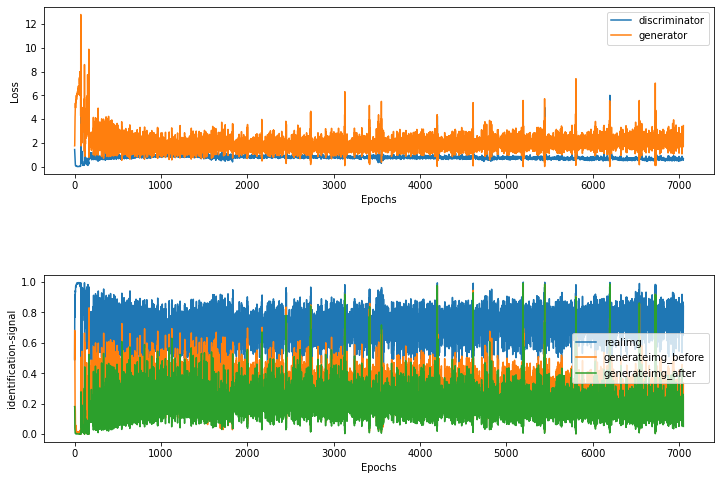

In [54]:
ganf.display_GAN_curv(12, 8, 10, 10, D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out)

In [4]:
cifarset = dset.CIFAR10(root='../torch_dataset/cifar10_root', download=True, train=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ])) 

Files already downloaded and verified


In [19]:
len(cifarset)

50000

In [21]:
len(cifarset[0]), cifarset[0][0].shape

(2, torch.Size([3, 32, 32]))

In [41]:
chlist = [100, 512, 256, 128, 3]
klist = [3, 4, 4, 4]
strdlist = [1, 2, 2, 2]
padlist = [0, 0, 1, 1]
opadlist = [0, 0, 0, 0]

gencifar = ganmd.Generator(chlist, klist, strdlist, padlist, opadlist)

summary(model = gencifar, input_size = (1, 100, 1, 1), depth = 4)

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     --                        --
├─Sequential: 1-1                             [1, 3, 32, 32]            --
│    └─Convtp_Bn_ReLu: 2-1                    [1, 512, 3, 3]            --
│    │    └─Sequential: 3-1                   [1, 512, 3, 3]            --
│    │    │    └─ConvTranspose2d: 4-1         [1, 512, 3, 3]            461,312
│    │    │    └─BatchNorm2d: 4-2             [1, 512, 3, 3]            1,024
│    │    │    └─ReLU: 4-3                    [1, 512, 3, 3]            --
│    └─Convtp_Bn_ReLu: 2-2                    [1, 256, 8, 8]            --
│    │    └─Sequential: 3-2                   [1, 256, 8, 8]            --
│    │    │    └─ConvTranspose2d: 4-4         [1, 256, 8, 8]            2,097,408
│    │    │    └─BatchNorm2d: 4-5             [1, 256, 8, 8]            512
│    │    │    └─ReLU: 4-6                    [1, 256, 8, 8]            --
│   

In [42]:
chlist = [3, 128, 256, 512, 1]
klist = [4, 4, 3, 3]
strdlist = [2, 2, 2, 1]
padlist = [1, 1, 0, 0]
ngsllist = [0.2, 0.2, 0.2, 0]

discifar = ganmd.Discriminator(chlist, klist, strdlist, padlist, ngsllist)

summary(model = discifar, input_size = (1, 3, 32, 32), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv_LeakyReLU: 2-1               [1, 128, 16, 16]          --
│    │    └─Sequential: 3-1              [1, 128, 16, 16]          --
│    │    │    └─Conv2d: 4-1             [1, 128, 16, 16]          6,272
│    │    │    └─LeakyReLU: 4-2          [1, 128, 16, 16]          --
│    └─Conv_Bn_LeakyReLU: 2-2            [1, 256, 8, 8]            --
│    │    └─Sequential: 3-2              [1, 256, 8, 8]            --
│    │    │    └─Conv2d: 4-3             [1, 256, 8, 8]            524,544
│    │    │    └─BatchNorm2d: 4-4        [1, 256, 8, 8]            512
│    │    │    └─LeakyReLU: 4-5          [1, 256, 8, 8]            --
│    └─Conv_Bn_LeakyReLU: 2-3            [1, 512, 3, 3]            --
│    │    └─Sequential: 3-3              [1, 512, 3, 3]            --
│    │

In [43]:
batch_size = 256
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(cifarset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)


# オプティマイザ−のセットアップ
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(discifar.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(gencifar.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [44]:
epochs = 30
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN/DCGAN/cifar'
dispinterval = 64
testgen_interval = 5


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_gan(epochs, dl, device, nz, discifar, gencifar, 
                                                                     criterion, optimizerG, optimizerD, 
                                                                     dispinterval,
                                                                     testgen_interval, fixed_noise, outf)

[1/30][1/196] Loss_D: 1.432 Loss_G: 2.132 D(x): 0.521 D(G(z)): 0.525/0.125
[1/30][65/196] Loss_D: 0.054 Loss_G: 6.585 D(x): 0.963 D(G(z)): 0.015/0.001
[1/30][129/196] Loss_D: 0.117 Loss_G: 4.024 D(x): 0.941 D(G(z)): 0.048/0.020
[1/30][193/196] Loss_D: 0.572 Loss_G: 1.758 D(x): 0.673 D(G(z)): 0.009/0.253
[2/30][1/196] Loss_D: 0.203 Loss_G: 3.503 D(x): 0.920 D(G(z)): 0.093/0.041
[2/30][65/196] Loss_D: 0.380 Loss_G: 4.821 D(x): 0.924 D(G(z)): 0.225/0.012
[2/30][129/196] Loss_D: 0.569 Loss_G: 3.580 D(x): 0.790 D(G(z)): 0.215/0.044
[2/30][193/196] Loss_D: 0.555 Loss_G: 2.711 D(x): 0.837 D(G(z)): 0.281/0.083
[3/30][1/196] Loss_D: 0.660 Loss_G: 3.377 D(x): 0.839 D(G(z)): 0.344/0.044
[3/30][65/196] Loss_D: 1.651 Loss_G: 3.573 D(x): 0.299 D(G(z)): 0.011/0.045
[3/30][129/196] Loss_D: 0.607 Loss_G: 4.178 D(x): 0.814 D(G(z)): 0.277/0.023
[3/30][193/196] Loss_D: 0.453 Loss_G: 3.367 D(x): 0.788 D(G(z)): 0.138/0.053
[4/30][1/196] Loss_D: 0.515 Loss_G: 3.935 D(x): 0.781 D(G(z)): 0.181/0.033
[4/30][65/

[27/30][193/196] Loss_D: 0.121 Loss_G: 4.614 D(x): 0.933 D(G(z)): 0.042/0.024
[28/30][1/196] Loss_D: 0.185 Loss_G: 4.430 D(x): 0.911 D(G(z)): 0.067/0.026
[28/30][65/196] Loss_D: 0.029 Loss_G: 5.179 D(x): 0.983 D(G(z)): 0.012/0.013
[28/30][129/196] Loss_D: 0.123 Loss_G: 5.206 D(x): 0.979 D(G(z)): 0.090/0.012
[28/30][193/196] Loss_D: 0.221 Loss_G: 5.459 D(x): 0.945 D(G(z)): 0.125/0.011
[29/30][1/196] Loss_D: 0.188 Loss_G: 4.060 D(x): 0.887 D(G(z)): 0.045/0.034
[29/30][65/196] Loss_D: 0.045 Loss_G: 6.141 D(x): 0.964 D(G(z)): 0.004/0.005
[29/30][129/196] Loss_D: 0.074 Loss_G: 4.248 D(x): 0.948 D(G(z)): 0.015/0.032
[29/30][193/196] Loss_D: 0.055 Loss_G: 5.612 D(x): 0.959 D(G(z)): 0.009/0.011
[30/30][1/196] Loss_D: 2.958 Loss_G: 16.350 D(x): 0.982 D(G(z)): 0.697/0.000
[30/30][65/196] Loss_D: 0.158 Loss_G: 4.949 D(x): 0.893 D(G(z)): 0.024/0.016
[30/30][129/196] Loss_D: 0.078 Loss_G: 4.965 D(x): 0.979 D(G(z)): 0.051/0.015
[30/30][193/196] Loss_D: 0.236 Loss_G: 4.400 D(x): 0.964 D(G(z)): 0.161/

In [15]:
################-------------------------CGAN----------------------------#############################
classes = 10
nz = 100

chlist = [nz + classes, 512, 256, 128, 1]
klist = [3, 3, 4, 4]
strdlist = [1, 2, 2, 2]
padlist = [0, 0, 1, 1]
opadlist = [0, 0, 0, 0]

cgene = ganmd.Generator(chlist, klist, strdlist, padlist, opadlist)

summary(model = cgene, input_size = (1, nz + classes, 1, 1), depth = 4)

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     --                        --
├─Sequential: 1-1                             [1, 1, 28, 28]            --
│    └─Convtp_Bn_ReLu: 2-1                    [1, 512, 3, 3]            --
│    │    └─Sequential: 3-1                   [1, 512, 3, 3]            --
│    │    │    └─ConvTranspose2d: 4-1         [1, 512, 3, 3]            507,392
│    │    │    └─BatchNorm2d: 4-2             [1, 512, 3, 3]            1,024
│    │    │    └─ReLU: 4-3                    [1, 512, 3, 3]            --
│    └─Convtp_Bn_ReLu: 2-2                    [1, 256, 7, 7]            --
│    │    └─Sequential: 3-2                   [1, 256, 7, 7]            --
│    │    │    └─ConvTranspose2d: 4-4         [1, 256, 7, 7]            1,179,904
│    │    │    └─BatchNorm2d: 4-5             [1, 256, 7, 7]            512
│    │    │    └─ReLU: 4-6                    [1, 256, 7, 7]            --
│   

In [16]:

chlist = [classes + 1, 128, 256, 512, 1]
klist = [4, 4, 3, 3]
strdlist = [2, 2, 2, 1]
padlist = [1, 1, 0, 0]
ngsllist = [0.2, 0.2, 0.2, 0]

cdisc = ganmd.Discriminator(chlist, klist, strdlist, padlist, ngsllist)

summary(model = cdisc, input_size = (1, classes + 1, 28, 28), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv_LeakyReLU: 2-1               [1, 128, 14, 14]          --
│    │    └─Sequential: 3-1              [1, 128, 14, 14]          --
│    │    │    └─Conv2d: 4-1             [1, 128, 14, 14]          22,656
│    │    │    └─LeakyReLU: 4-2          [1, 128, 14, 14]          --
│    └─Conv_Bn_LeakyReLU: 2-2            [1, 256, 7, 7]            --
│    │    └─Sequential: 3-2              [1, 256, 7, 7]            --
│    │    │    └─Conv2d: 4-3             [1, 256, 7, 7]            524,544
│    │    │    └─BatchNorm2d: 4-4        [1, 256, 7, 7]            512
│    │    │    └─LeakyReLU: 4-5          [1, 256, 7, 7]            --
│    └─Conv_Bn_LeakyReLU: 2-3            [1, 512, 3, 3]            --
│    │    └─Sequential: 3-3              [1, 512, 3, 3]            --
│    

In [17]:
batch_size = 256
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(dataset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


#固定ノイズ
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
# 確認用のラベル。0〜9のラベルの繰り返し
fixed_label = [i for i in range(10)] * (batch_size // 10)
for i in range(batch_size % 10):
    fixed_label.append(i)
fixed_label = torch.tensor(fixed_label, dtype=torch.long, device=device)
# 確認用のノイズとラベルを連結
fixed_noise_label = ganf.concat_noise_label(fixed_noise, fixed_label, device, classes)




# オプティマイザ−のセットアップ
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(cdisc.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(cgene.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [12]:
epochs = 30
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN/CGAN/mnist'
dispinterval = 64
testgen_interval = 5


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_cgan(epochs, dl, classes, device, nz, cdisc, cgene, 
                                                                     criterion, optimizerG, optimizerD, 
                                                                     dispinterval,
                                                                     testgen_interval, fixed_noise_label, outf)

[1/30][1/235] Loss_D: 1.429 Loss_G: 1.247 D(x): 0.482 D(G(z)): 0.477/0.308
[1/30][65/235] Loss_D: 0.005 Loss_G: 7.084 D(x): 0.998 D(G(z)): 0.002/0.001
[1/30][129/235] Loss_D: 0.243 Loss_G: 4.961 D(x): 0.862 D(G(z)): 0.048/0.013
[1/30][193/235] Loss_D: 1.175 Loss_G: 4.013 D(x): 0.826 D(G(z)): 0.523/0.032
[2/30][1/235] Loss_D: 0.706 Loss_G: 4.392 D(x): 0.884 D(G(z)): 0.360/0.028
[2/30][65/235] Loss_D: 0.962 Loss_G: 3.189 D(x): 0.874 D(G(z)): 0.509/0.053
[2/30][129/235] Loss_D: 0.895 Loss_G: 1.339 D(x): 0.585 D(G(z)): 0.241/0.299
[2/30][193/235] Loss_D: 0.628 Loss_G: 2.212 D(x): 0.755 D(G(z)): 0.253/0.139
[3/30][1/235] Loss_D: 0.757 Loss_G: 1.836 D(x): 0.754 D(G(z)): 0.326/0.199
[3/30][65/235] Loss_D: 0.865 Loss_G: 1.240 D(x): 0.533 D(G(z)): 0.135/0.335
[3/30][129/235] Loss_D: 0.786 Loss_G: 1.983 D(x): 0.829 D(G(z)): 0.414/0.169
[3/30][193/235] Loss_D: 0.712 Loss_G: 1.049 D(x): 0.711 D(G(z)): 0.281/0.377
[4/30][1/235] Loss_D: 1.096 Loss_G: 1.100 D(x): 0.496 D(G(z)): 0.250/0.370
[4/30][65/

[27/30][193/235] Loss_D: 0.408 Loss_G: 2.105 D(x): 0.767 D(G(z)): 0.129/0.125
[28/30][1/235] Loss_D: 1.119 Loss_G: 0.817 D(x): 0.633 D(G(z)): 0.474/0.447
[28/30][65/235] Loss_D: 0.788 Loss_G: 1.729 D(x): 0.538 D(G(z)): 0.149/0.182
[28/30][129/235] Loss_D: 1.179 Loss_G: 0.684 D(x): 0.716 D(G(z)): 0.563/0.510
[28/30][193/235] Loss_D: 2.114 Loss_G: 0.472 D(x): 0.510 D(G(z)): 0.756/0.626
[29/30][1/235] Loss_D: 2.421 Loss_G: 0.535 D(x): 0.191 D(G(z)): 0.515/0.589
[29/30][65/235] Loss_D: 1.118 Loss_G: 0.779 D(x): 0.872 D(G(z)): 0.621/0.464
[29/30][129/235] Loss_D: 1.670 Loss_G: 0.823 D(x): 0.310 D(G(z)): 0.379/0.443
[29/30][193/235] Loss_D: 0.547 Loss_G: 1.514 D(x): 0.732 D(G(z)): 0.207/0.224
[30/30][1/235] Loss_D: 0.511 Loss_G: 1.570 D(x): 0.770 D(G(z)): 0.218/0.214
[30/30][65/235] Loss_D: 0.428 Loss_G: 1.712 D(x): 0.788 D(G(z)): 0.170/0.185
[30/30][129/235] Loss_D: 1.045 Loss_G: 0.768 D(x): 0.846 D(G(z)): 0.581/0.468
[30/30][193/235] Loss_D: 1.365 Loss_G: 0.766 D(x): 0.619 D(G(z)): 0.581/0

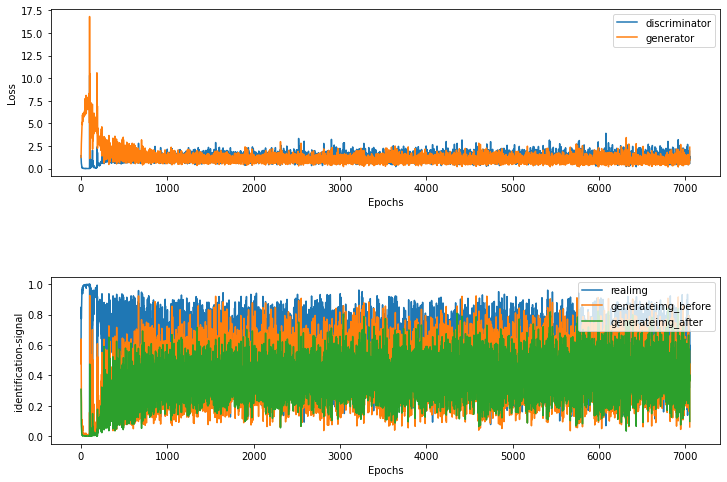

In [13]:
ganf.display_GAN_curv(12, 8, 10, 10, D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out)

In [18]:
#fashion-mnist
batch_size = 256
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(fmset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


#固定ノイズ
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
# 確認用のラベル。0〜9のラベルの繰り返し
fixed_label = [i for i in range(10)] * (batch_size // 10)
for i in range(batch_size % 10):
    fixed_label.append(i)
fixed_label = torch.tensor(fixed_label, dtype=torch.long, device=device)
# 確認用のノイズとラベルを連結
fixed_noise_label = ganf.concat_noise_label(fixed_noise, fixed_label, device, classes)




# オプティマイザ−のセットアップ
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(cdisc.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(cgene.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [19]:
epochs = 30
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN/CGAN/fm'
dispinterval = 64
testgen_interval = 5


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_cgan(epochs, dl, classes, device, nz, cdisc, cgene, 
                                                                     criterion, optimizerG, optimizerD, 
                                                                     dispinterval,
                                                                     testgen_interval, fixed_noise_label, outf)

[1/30][1/235] Loss_D: 1.415 Loss_G: 1.384 D(x): 0.568 D(G(z)): 0.560/0.263
[1/30][65/235] Loss_D: 0.074 Loss_G: 10.605 D(x): 0.991 D(G(z)): 0.060/0.000
[1/30][129/235] Loss_D: 0.075 Loss_G: 5.062 D(x): 0.963 D(G(z)): 0.030/0.010
[1/30][193/235] Loss_D: 0.424 Loss_G: 4.466 D(x): 0.788 D(G(z)): 0.061/0.020
[2/30][1/235] Loss_D: 0.224 Loss_G: 3.945 D(x): 0.958 D(G(z)): 0.153/0.027
[2/30][65/235] Loss_D: 0.888 Loss_G: 2.068 D(x): 0.663 D(G(z)): 0.267/0.167
[2/30][129/235] Loss_D: 1.074 Loss_G: 1.973 D(x): 0.754 D(G(z)): 0.514/0.164
[2/30][193/235] Loss_D: 0.629 Loss_G: 2.964 D(x): 0.812 D(G(z)): 0.312/0.068
[3/30][1/235] Loss_D: 0.740 Loss_G: 1.710 D(x): 0.630 D(G(z)): 0.186/0.219
[3/30][65/235] Loss_D: 0.936 Loss_G: 1.552 D(x): 0.469 D(G(z)): 0.060/0.254
[3/30][129/235] Loss_D: 1.277 Loss_G: 3.322 D(x): 0.923 D(G(z)): 0.649/0.051
[3/30][193/235] Loss_D: 1.158 Loss_G: 0.639 D(x): 0.420 D(G(z)): 0.142/0.558
[4/30][1/235] Loss_D: 0.994 Loss_G: 2.378 D(x): 0.723 D(G(z)): 0.433/0.125
[4/30][65

[27/30][193/235] Loss_D: 0.688 Loss_G: 2.137 D(x): 0.743 D(G(z)): 0.278/0.151
[28/30][1/235] Loss_D: 0.655 Loss_G: 2.339 D(x): 0.823 D(G(z)): 0.325/0.129
[28/30][65/235] Loss_D: 0.639 Loss_G: 2.126 D(x): 0.732 D(G(z)): 0.240/0.157
[28/30][129/235] Loss_D: 0.606 Loss_G: 2.783 D(x): 0.863 D(G(z)): 0.335/0.081
[28/30][193/235] Loss_D: 0.843 Loss_G: 2.671 D(x): 0.789 D(G(z)): 0.399/0.090
[29/30][1/235] Loss_D: 0.750 Loss_G: 3.273 D(x): 0.876 D(G(z)): 0.391/0.051
[29/30][65/235] Loss_D: 0.706 Loss_G: 1.505 D(x): 0.631 D(G(z)): 0.154/0.278
[29/30][129/235] Loss_D: 0.675 Loss_G: 2.082 D(x): 0.756 D(G(z)): 0.281/0.157
[29/30][193/235] Loss_D: 1.102 Loss_G: 0.867 D(x): 0.426 D(G(z)): 0.080/0.485
[30/30][1/235] Loss_D: 0.965 Loss_G: 0.806 D(x): 0.506 D(G(z)): 0.107/0.522
[30/30][65/235] Loss_D: 0.618 Loss_G: 2.477 D(x): 0.816 D(G(z)): 0.304/0.113
[30/30][129/235] Loss_D: 0.731 Loss_G: 2.168 D(x): 0.728 D(G(z)): 0.282/0.146
[30/30][193/235] Loss_D: 0.878 Loss_G: 2.928 D(x): 0.828 D(G(z)): 0.438/0

In [5]:
#cifar10
classes = 10
nz = 100

chlist = [nz + classes, 512, 256, 128, 3]
klist = [3, 4, 4, 4]
strdlist = [1, 2, 2, 2]
padlist = [0, 0, 1, 1]
opadlist = [0, 0, 0, 0]

gencifar = ganmd.Generator(chlist, klist, strdlist, padlist, opadlist)

summary(model = gencifar, input_size = (1, 110, 1, 1), depth = 4)

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     --                        --
├─Sequential: 1-1                             [1, 3, 32, 32]            --
│    └─Convtp_Bn_ReLu: 2-1                    [1, 512, 3, 3]            --
│    │    └─Sequential: 3-1                   [1, 512, 3, 3]            --
│    │    │    └─ConvTranspose2d: 4-1         [1, 512, 3, 3]            507,392
│    │    │    └─BatchNorm2d: 4-2             [1, 512, 3, 3]            1,024
│    │    │    └─ReLU: 4-3                    [1, 512, 3, 3]            --
│    └─Convtp_Bn_ReLu: 2-2                    [1, 256, 8, 8]            --
│    │    └─Sequential: 3-2                   [1, 256, 8, 8]            --
│    │    │    └─ConvTranspose2d: 4-4         [1, 256, 8, 8]            2,097,408
│    │    │    └─BatchNorm2d: 4-5             [1, 256, 8, 8]            512
│    │    │    └─ReLU: 4-6                    [1, 256, 8, 8]            --
│   

In [6]:
chlist = [classes + 3, 128, 256, 512, 1]
klist = [4, 4, 3, 3]
strdlist = [2, 2, 2, 1]
padlist = [1, 1, 0, 0]
ngsllist = [0.2, 0.2, 0.2, 0]

discifar = ganmd.Discriminator(chlist, klist, strdlist, padlist, ngsllist)

summary(model = discifar, input_size = (1, classes + 3, 32, 32), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv_LeakyReLU: 2-1               [1, 128, 16, 16]          --
│    │    └─Sequential: 3-1              [1, 128, 16, 16]          --
│    │    │    └─Conv2d: 4-1             [1, 128, 16, 16]          26,752
│    │    │    └─LeakyReLU: 4-2          [1, 128, 16, 16]          --
│    └─Conv_Bn_LeakyReLU: 2-2            [1, 256, 8, 8]            --
│    │    └─Sequential: 3-2              [1, 256, 8, 8]            --
│    │    │    └─Conv2d: 4-3             [1, 256, 8, 8]            524,544
│    │    │    └─BatchNorm2d: 4-4        [1, 256, 8, 8]            512
│    │    │    └─LeakyReLU: 4-5          [1, 256, 8, 8]            --
│    └─Conv_Bn_LeakyReLU: 2-3            [1, 512, 3, 3]            --
│    │    └─Sequential: 3-3              [1, 512, 3, 3]            --
│    

In [9]:
#cifar
batch_size = 256
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(cifarset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


#固定ノイズ
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
# 確認用のラベル。0〜9のラベルの繰り返し
fixed_label = [i for i in range(10)] * (batch_size // 10)
for i in range(batch_size % 10):
    fixed_label.append(i)
fixed_label = torch.tensor(fixed_label, dtype=torch.long, device=device)
# 確認用のノイズとラベルを連結
fixed_noise_label = ganf.concat_noise_label(fixed_noise, fixed_label, device, classes)




# オプティマイザ−のセットアップ
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(discifar.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(gencifar.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [10]:
epochs = 30
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN/CGAN/cifar'
dispinterval = 64
testgen_interval = 5


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_cgan(epochs, dl, classes, device, nz, discifar, gencifar, 
                                                                     criterion, optimizerG, optimizerD, 
                                                                     dispinterval,
                                                                     testgen_interval, fixed_noise_label, outf)

[1/30][1/196] Loss_D: 1.399 Loss_G: 1.812 D(x): 0.527 D(G(z)): 0.521/0.169
[1/30][65/196] Loss_D: 0.020 Loss_G: 11.978 D(x): 0.981 D(G(z)): 0.000/0.000
[1/30][129/196] Loss_D: 0.059 Loss_G: 6.576 D(x): 0.956 D(G(z)): 0.011/0.002
[1/30][193/196] Loss_D: 0.353 Loss_G: 3.734 D(x): 0.766 D(G(z)): 0.049/0.029
[2/30][1/196] Loss_D: 0.763 Loss_G: 5.592 D(x): 0.911 D(G(z)): 0.460/0.004
[2/30][65/196] Loss_D: 1.064 Loss_G: 2.968 D(x): 0.419 D(G(z)): 0.015/0.067
[2/30][129/196] Loss_D: 0.737 Loss_G: 1.918 D(x): 0.691 D(G(z)): 0.223/0.183
[2/30][193/196] Loss_D: 0.867 Loss_G: 1.641 D(x): 0.638 D(G(z)): 0.284/0.227
[3/30][1/196] Loss_D: 0.843 Loss_G: 3.010 D(x): 0.798 D(G(z)): 0.423/0.061
[3/30][65/196] Loss_D: 0.692 Loss_G: 2.268 D(x): 0.628 D(G(z)): 0.139/0.126
[3/30][129/196] Loss_D: 0.716 Loss_G: 1.657 D(x): 0.687 D(G(z)): 0.219/0.216
[3/30][193/196] Loss_D: 0.585 Loss_G: 3.650 D(x): 0.825 D(G(z)): 0.285/0.037
[4/30][1/196] Loss_D: 0.835 Loss_G: 2.659 D(x): 0.755 D(G(z)): 0.364/0.096
[4/30][65

[27/30][193/196] Loss_D: 0.460 Loss_G: 1.475 D(x): 0.711 D(G(z)): 0.042/0.334
[28/30][1/196] Loss_D: 0.463 Loss_G: 2.689 D(x): 0.708 D(G(z)): 0.021/0.176
[28/30][65/196] Loss_D: 0.076 Loss_G: 4.490 D(x): 0.945 D(G(z)): 0.016/0.021
[28/30][129/196] Loss_D: 0.126 Loss_G: 4.901 D(x): 0.985 D(G(z)): 0.101/0.012
[28/30][193/196] Loss_D: 0.755 Loss_G: 2.409 D(x): 0.543 D(G(z)): 0.014/0.144
[29/30][1/196] Loss_D: 0.197 Loss_G: 3.902 D(x): 0.961 D(G(z)): 0.132/0.032
[29/30][65/196] Loss_D: 0.147 Loss_G: 3.938 D(x): 0.990 D(G(z)): 0.121/0.030
[29/30][129/196] Loss_D: 0.166 Loss_G: 4.654 D(x): 0.965 D(G(z)): 0.116/0.015
[29/30][193/196] Loss_D: 0.024 Loss_G: 5.129 D(x): 0.981 D(G(z)): 0.005/0.011
[30/30][1/196] Loss_D: 0.212 Loss_G: 6.362 D(x): 0.993 D(G(z)): 0.156/0.003
[30/30][65/196] Loss_D: 0.039 Loss_G: 6.548 D(x): 0.965 D(G(z)): 0.003/0.003
[30/30][129/196] Loss_D: 0.494 Loss_G: 4.265 D(x): 0.854 D(G(z)): 0.235/0.027
[30/30][193/196] Loss_D: 0.110 Loss_G: 4.013 D(x): 0.956 D(G(z)): 0.058/0

In [ ]:
#########----------------------------LSGAN------------------------------###########


In [30]:
currentdir = os.getcwd()
currentdir

'C:\\Users\\mkopm\\ipynbs'

In [32]:
os.pardir

'..'

In [33]:
sys.path

['C:\\Users\\mkopm\\ipynbs',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\python38.zip',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\DLLs',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch',
 '',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib\\site-packages',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib\\site-packages\\huggingface_hub-0.0.17-py3.8.egg',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib\\site-packages\\win32',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib\\site-packages\\sacremoses-0.0.43-py3.8.egg',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\mkopm\\.ipython',
 '..']

In [47]:
trf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [48]:
data = trf(myset.data)

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [49]:
data.shape

torch.Size([70000, 28, 28])

In [41]:
data[0]

tensor([[ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,

In [42]:
torch.mean(data), torch.std(data)

(tensor(65.7719), tensor(157.3087))